Inicializando o projeto, Importando as bibliotecas, autenticando e importando o ID do projeto

In [ ]:
!pip install geobr geopandas osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.2
    Uninstalling shapely-2.1.2:
      Successfully uninstalled shapely-2.1.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.1.1
    Uninstalling geopandas-1.1.1:
      Successfully uninstalled geopandas-1.1.1


In [ ]:
import ee
import geemap
import geobr
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
ee.Authenticate()

In [ ]:
try:
  ee.Initialize(project = 'useful-art-476102-v8')
except ee.Initialize.EEException:
  ee.Authenticate()
  ee.Initialize(project = 'useful-art-476102-v8')

Definindo o Mapa de Alagoas

In [ ]:
Map = geemap.Map()
Map.centerObject(maceio_geometry,12)

Iniciando o processo...
Baixando dados de bairros do Brasil (ano 2010)... Isso pode levar alguns minutos.
Download concluído.
Filtrando bairros para o município: 2704302
Total de 50 bairros encontrados em Maceió.
Plotando mapa dos bairros de Maceió...


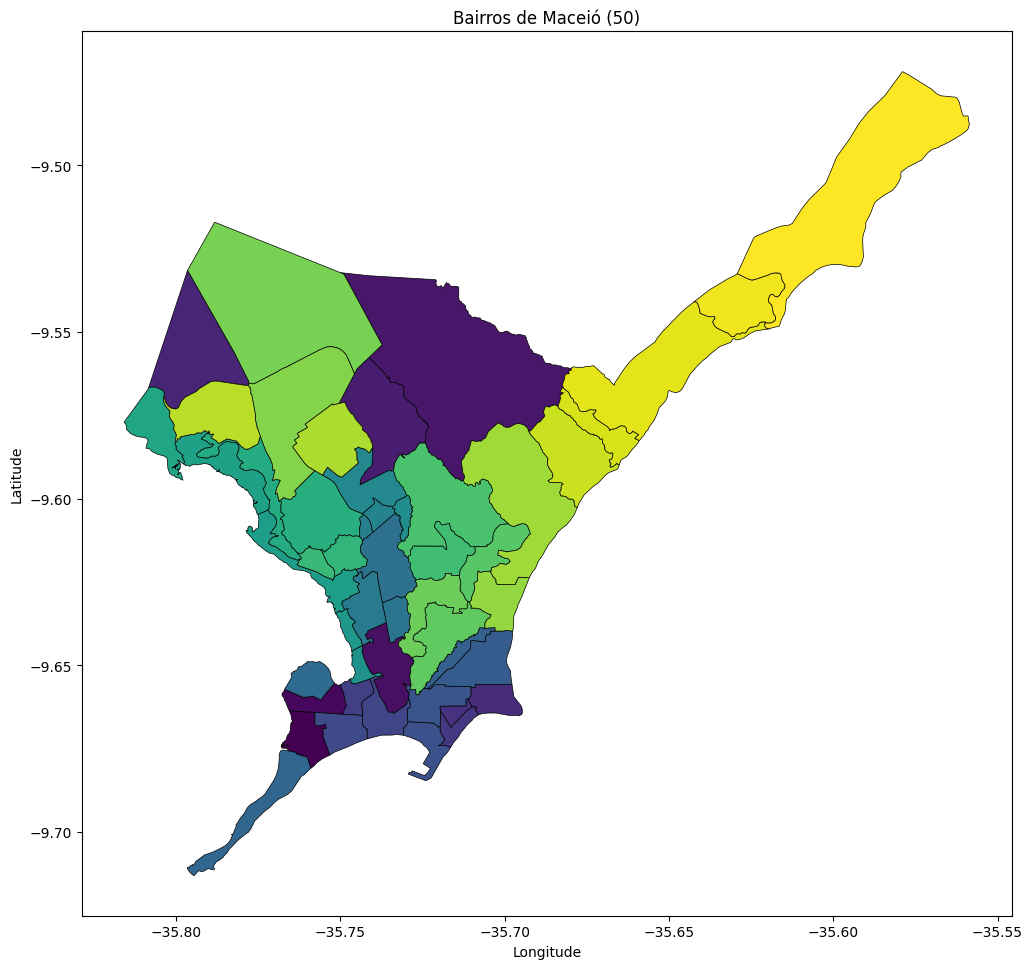


--- Lista de Bairros (Um por Um) ---
Nome: Trapiche Da Barra
Código: 270430205049.0
--------------------
Nome: Ponta Grossa
Código: 270430205036.0
--------------------
Nome: Farol
Código: 270430205013.0
--------------------
Nome: Benedito Bentes
Código: 270430205004.0
--------------------
Nome: Antares
Código: 270430205001.0
--------------------
Nome: Santos Dumont
Código: 270430205045.0
--------------------
Nome: Ponta Verde
Código: 270430205038.0
--------------------
Nome: Ponta Da Terra
Código: 270430205035.0
--------------------
Nome: Pajuçara
Código: 270430205029.0
--------------------
Nome: Levada
Código: 270430205025.0
--------------------
Nome: Centro
Código: 270430205007.0
--------------------
Nome: Prado
Código: 270430205039.0
--------------------
Nome: Jaraguá
Código: 270430205022.0
--------------------
Nome: Poço
Código: 270430205034.0
--------------------
Nome: Jatiúca
Código: 270430205024.0
--------------------
Nome: Mangabeiras
Código: 270430205026.0
-------------------

In [ ]:
import geobr
import geemap
import matplotlib.pyplot as plt

print("Iniciando o processo...")

CODIGO_MACEIO = 2704302

print(f"Baixando dados de bairros do Brasil (ano 2010)... Isso pode levar alguns minutos.")
try:
    todos_bairros_gdf = geobr.read_neighborhood(year=2010)
    print("Download concluído.")

except Exception as e:
    print(f"Erro ao baixar os dados de bairros: {e}")
    print("Verifique sua conexão com a internet ou tente novamente mais tarde.")
    exit()

print(f"Filtrando bairros para o município: {CODIGO_MACEIO}")

maceio_bairros_gdf = todos_bairros_gdf[
    todos_bairros_gdf['code_muni'] == CODIGO_MACEIO
]

if maceio_bairros_gdf.empty:
    print(f"Nenhum bairro encontrado para o código {CODIGO_MACEIO} no ano de 2010.")
else:
    print(f"Total de {len(maceio_bairros_gdf)} bairros encontrados em Maceió.")

    print("Plotando mapa dos bairros de Maceió...")
    fig, ax = plt.subplots(figsize=(12, 12))
    maceio_bairros_gdf.plot(
        ax=ax,
        edgecolor='black',
        linewidth=0.5,
        cmap='viridis',
        legend=False
    )
    ax.set_title(f"Bairros de Maceió ({len(maceio_bairros_gdf)})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

    print("\n--- Lista de Bairros (Um por Um) ---")

    for index, bairro in maceio_bairros_gdf.iterrows():
        nome_bairro = bairro['name_neighborhood']
        codigo_bairro = bairro['code_neighborhood']
        geometria = bairro['geometry']

        print(f"Nome: {nome_bairro}")
        print(f"Código: {codigo_bairro}")
        print("-" * 20)

    print("\nConvertendo GeoDataFrame dos bairros para o GEE...")
    try:
        maceio_bairros_ee = geemap.geopandas_to_ee(maceio_bairros_gdf)
        print("Conversão para o GEE concluída.")

    except Exception as e:
        print(f"Erro ao converter para o GEE (verifique se o geemap/ee estão autenticados): {e}")

In [ ]:
maceio_geometry = maceio_bairros_ee.geometry()
# Define o catálogo de imagens
sentinel = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
    .filterBounds(maceio_geometry)
    .filterDate('2019-01-01', '2025-10-25')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
)

In [ ]:
image = sentinel.median().clip(maceio_geometry)

ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

In [ ]:
area_verde = ndvi.gt(0.3)

area_pixel = ee.Image.pixelArea()

area_verde_m2 = area_pixel.updateMask(area_verde)

area_total_verde_dict = area_verde_m2.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=maceio_geometry,
    scale=10,
    maxPixels=1e13
)

area_verde_m2_ee = ee.Number(area_total_verde_dict.get('area'))
area_total_m2_ee = ee.Number(maceio_geometry.area(maxError=1))

area_verde_km2_ee = area_verde_m2_ee.divide(1e6)
area_total_km2_ee = area_total_m2_ee.divide(1e6)

percentual_verde_ee = area_verde_km2_ee.divide(area_total_km2_ee).multiply(100)

resultados_ee = ee.Dictionary({
    'area_verde_km2': area_verde_km2_ee,
    'area_total_km2': area_total_km2_ee,
    'percentual_verde': percentual_verde_ee
})

print(resultados_ee.getInfo())

{'area_total_km2': 198.58520110816838, 'area_verde_km2': 107.8861556587174, 'percentual_verde': 54.327389481531576}


In [ ]:
print("Buscando resultados do GEE...")
resultados_py = resultados_ee.getInfo()

# Arredondar os valores do Python (Isto estava certo)
area_verde_km2_val = round(resultados_py['area_verde_km2'], 2)
area_total_km2_val = round(resultados_py['area_total_km2'], 2)
percentual_verde_val = round(resultados_py['percentual_verde'], 2)

# Imprimir (Recomendo usar :.2f para garantir 2 casas decimais)
print(f"🟩 --- RESULTADOS DE ÁREA VERDE EM MACEIÓ --- 🟩")
print(f"Área verde em Km²: {area_verde_km2_val:,.2f}")
print(f"Área total de Maceió em Km²: {area_total_km2_val:,.2f}")
print(f"Percentual de área verde: {percentual_verde_val:,.2f}%")

Buscando resultados do GEE...
🟩 --- RESULTADOS DE ÁREA VERDE EM MACEIÓ --- 🟩
Área verde em Km²: 107.89
Área total de Maceió em Km²: 198.59
Percentual de área verde: 54.33%


In [ ]:


# 1. Cor Verdadeira (Original, mas com 'gamma' para clarear)
vis_cor_verdadeira = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
    'gamma': 1.4
}

# 2. Falsa Cor (NIR, R, G) - Ótimo para destacar vegetação
vis_falsa_cor = {
  'min': 0,
  'max': 4000,
  'bands': ['B8', 'B4', 'B3']
}

# 3. NDVI (Índice de Vegetação)
vis_ndvi = {
  'min': -0.5,
  'max': 1,
  'palette': ['#000080', '#CE7E45', '#FFFFE0', '#008000', '#006400']
}


In [ ]:
Map.addLayer(composite, vis_cor_verdadeira, '1. Cor Verdadeira (Melhorada)')
Map.addLayer(composite, vis_falsa_cor, '2. Falsa Cor (Foco em Vegetação)')
Map.addLayer(ndvi, vis_ndvi, '3. NDVI (Análise de Vegetação)')

# Usamos 'maceio_bairros_ee' (nossa FeatureCollection)
Map.addLayer(maceio_bairros_ee, {'color': 'yellow', 'fillColor': '00000000'}, 'Limite Bairros Maceió')

# Exibe o mapa
display(Map)

NameError: name 'composite' is not defined

In [ ]:
maceio = estados.filter(ee.Filter.And(
    ee.Filter.eq('ADM0_NAME', 'Brazil'),
    ee.Filter.eq('ADM1_NAME', 'Alagoas'),
    ee.Filter.eq('ADM2_NAME', 'Maceio')
))

count_maceio = maceio.size().getInfo()
print(f'Foi encontrado {count_maceio} de ocorrências')

Foi encontrado 1 de ocorrências


In [ ]:
sentinel_maceio = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
  .filterBounds(maceio.geometry()) \
  .filterDate('2019-01-01', '2025-10-25') \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40))

mosaic_maceio = sentinel_maceio.median().clip(maceio)

In [ ]:
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

Map.addLayer(mosaic_maceio, vis, 'Sentinel-2 Maceio (Mosaico Cortado)')
Map.addLayer(maceio, {'color': 'yellow', 'fillColor': '00000000'}, 'Limite Maceio')
Map.centerObject(maceio, 11)

Map

Map(bottom=275999.0, center=[-9.518618533839641, -35.709439246370714], controls=(WidgetControl(options=['posit…

In [ ]:
ndvi = mosaic_maceio.normalizedDifference(['B8', 'B4']).rename('NDVI')

# 6️⃣ Máscara e cálculo da área verde
area_verde = ndvi.gt(0.3)
area_pixel = ee.Image.pixelArea()
area_verde_m2 = area_pixel.updateMask(area_verde)

# Criar uma grade (grid) sobre Maceió usando projeção geográfica padrão
grid = maceio.geometry().coveringGrid('EPSG:4326', scale=5000)

area_total_verde = area_verde_m2.reduceRegion(
    reducer=ee.Reducer.sum(),   # <-- ESTA É A CORREÇÃO
    geometry=maceio.geometry(),
    scale=300,                   # Usar a escala do Sentinel-2 (ou 30m) é comum
    bestEffort=True,
    maxPixels=1e9
)

# 7️⃣ Conversão para km² e exibição
area_km2 = area_total_verde.getNumber('area').divide(1e6)
print('Área verde estimada (km²):', area_km2.getInfo())


Área verde estimada (km²): 396.52441097162983


In [ ]:
import ee
import geemap

# --- Autenticação e Inicialização ---
try:
  ee.Initialize(project = 'useful-art-476102-v8')
except ee.Initialize.EEException:
  ee.Authenticate()
  ee.Initialize(project = 'useful-art-476102-v8')

# --- Definindo o Mapa ---
# Inicializa o mapa (vamos centralizar depois)
Map = geemap.Map()


# --- Definindo a Área de Interesse (Maceió) ---

# CORREÇÃO: Este é o ID correto e atualizado para os municípios de 2020 do IBGE
municipios_ibge = ee.FeatureCollection("projects/ee-brazil-ibge/assets/territorios/municipios_2020")

# Seu filtro está perfeito e funciona com a coleção correta
maceio_ee = municipios_ibge.filter(
    ee.Filter.And(
        ee.Filter.eq('SIGLA_UF', 'AL'),
        ee.Filter.eq('NM_MUN', 'Maceió')
    )
).first()

# --- Centralizando o Mapa ---
# Agora que temos a geometria, centralizamos o mapa nela
Map.centerObject(maceio_ee, 12)

# --- Coletando e Processando Imagens ---

# Define o catálogo de imagens
sentinel = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(maceio_ee.geometry()).filterDate('2023-01-01', '2023-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# Criar mosaico e clipar
image = sentinel.median().clip(maceio_ee)

# Calcular NDVI
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# --- Definindo Visualizações ---

# 1. Cor Verdadeira
vis_cor_verdadeira = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
    'gamma': 1.4
}

# 2. Falsa Cor (Vegetação)
vis_falsa_cor = {
  'min': 0,
  'max': 4000,
  'bands': ['B8', 'B4', 'B3']
}

# 3. NDVI
vis_ndvi = {
  'min': -0.5,
  'max': 1,
  'palette': ['#000080', '#CE7E45', '#FFFFE0', '#008000', '#006400']
}

# --- Adicionando Camadas ao Mapa ---

Map.addLayer(image, vis_cor_verdadeira, '1. Cor Verdadeira (Maceió)')
Map.addLayer(image, vis_falsa_cor, '2. Falsa Cor (Foco em Vegetação)')
Map.addLayer(ndvi, vis_ndvi, '3. NDVI (Análise de Vegetação)')
Map.addLayer(maceio_ee, {'color': 'yellow', 'fillColor': '00000000'}, 'Limite Maceió')
Map

EEException: Collection.loadTable: Asset 'projects/ee-brazil-ibge/assets/territorios/municipios_2020' does not exist or doesn't allow this operation.

Google Earth Engine Inicializado com sucesso.
Iniciando o processo...
Baixando dados de bairros do Brasil (ano 2010)...
Download concluído.
Filtrando bairros para o município: 2704302
Total de 50 bairros encontrados em Maceió.
Plotando mapa estático dos bairros de Maceió...


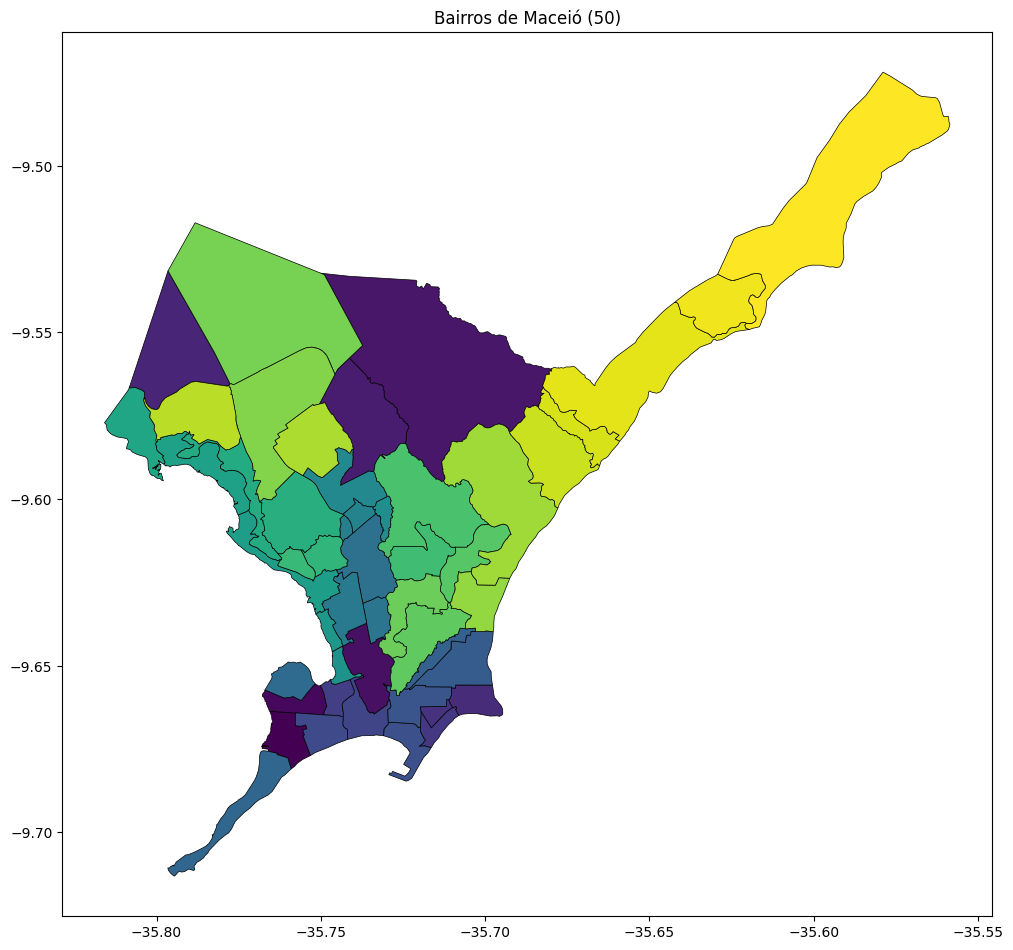


Convertendo GeoDataFrame dos bairros para o GEE...
Conversão para o GEE concluída.
Geometria do GEE criada.
Baixando e processando imagens Sentinel-2...
Imagem composta e NDVI criados.
Criando mapa interativo...


Map(center=[-9.582701558525649, -35.71818245348589], controls=(WidgetControl(options=['position', 'transparent…


Iniciando cálculo de área verde...
Buscando resultados do GEE...
🟩 --- RESULTADOS DE ÁREA VERDE EM MACEIÓ --- 🟩
Área verde em Km²: 107.89
Área total de Maceió em Km²: 198.59
Percentual de área verde: 54.33%

Processo finalizado.


In [ ]:
# --- 1. IMPORTAÇÕES (Tudo no início) ---
!pip install geobr geopandas osmnx

import ee
import geemap
import geobr
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display

# --- 2. AUTENTICAÇÃO E INICIALIZAÇÃO ---
try:
    # Tenta inicializar primeiro (se já estiver autenticado)
    ee.Initialize(project = 'useful-art-476102-v8')
except Exception as e:
    # Se falhar, pede autenticação e tenta de novo
    print(f"Inicialização falhou, autenticando... (Erro: {e})")
    ee.Authenticate()
    ee.Initialize(project = 'useful-art-476102-v8')

print("Google Earth Engine Inicializado com sucesso.")

# --- 3. DOWNLOAD E FILTRO DOS DADOS LOCAIS (geobr) ---
print("Iniciando o processo...")

CODIGO_MACEIO = 2704302

print(f"Baixando dados de bairros do Brasil (ano 2010)...")
try:
    todos_bairros_gdf = geobr.read_neighborhood(year=2010)
    print("Download concluído.")
except Exception as e:
    print(f"Erro ao baixar os dados de bairros: {e}")
    exit()

print(f"Filtrando bairros para o município: {CODIGO_MACEIO}")
maceio_bairros_gdf = todos_bairros_gdf[
    todos_bairros_gdf['code_muni'] == CODIGO_MACEIO
]

if maceio_bairros_gdf.empty:
    print(f"Nenhum bairro encontrado para o código {CODIGO_MACEIO} no ano de 2010.")
else:
    print(f"Total de {len(maceio_bairros_gdf)} bairros encontrados em Maceió.")

    print("Plotando mapa estático dos bairros de Maceió...")
    fig, ax = plt.subplots(figsize=(12, 12))
    maceio_bairros_gdf.plot(
        ax=ax,
        edgecolor='black',
        linewidth=0.5,
        cmap='viridis',
        legend=False
    )
    ax.set_title(f"Bairros de Maceió ({len(maceio_bairros_gdf)})")
    plt.show()

    # (O loop que imprime os nomes foi omitido para encurtar)
    # print("\n--- Lista de Bairros (Um por Um) ---") ...

    # --- 4. CONVERSÃO PARA O GEE E DEFINIÇÃO DA GEOMETRIA ---
    print("\nConvertendo GeoDataFrame dos bairros para o GEE...")
    try:
        maceio_bairros_ee = geemap.geopandas_to_ee(maceio_bairros_gdf)
        print("Conversão para o GEE concluída.")

        # Geometria unificada de Maceió
        maceio_geometry = maceio_bairros_ee.geometry()
        print("Geometria do GEE criada.")

    except Exception as e:
        print(f"Erro ao converter para o GEE: {e}")
        exit() # Sair se a conversão falhar

    # --- 5. PROCESSAMENTO DE IMAGEM (GEE) ---
    print("Baixando e processando imagens Sentinel-2...")
    sentinel = (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .filterBounds(maceio_geometry)
        .filterDate('2019-01-01', '2025-10-25')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    )

    # CORREÇÃO: A variável foi nomeada 'image'
    image = sentinel.median().clip(maceio_geometry)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    print("Imagem composta e NDVI criados.")

    # --- 6. VISUALIZAÇÃO DO MAPA (Corrigido) ---
    # CORREÇÃO: Bloco de mapa movido para DEPOIS da definição de
    # 'maceio_geometry', 'image', e 'ndvi'.

    print("Criando mapa interativo...")
    Map = geemap.Map()
    Map.centerObject(maceio_geometry, 12) # Agora 'maceio_geometry' existe

    # 1. Cor Verdadeira
    vis_cor_verdadeira = {
        'min': 0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2'],
        'gamma': 1.4
    }
    # 2. Falsa Cor
    vis_falsa_cor = {
      'min': 0,
      'max': 4000,
      'bands': ['B8', 'B4', 'B3']
    }
    # 3. NDVI
    vis_ndvi = {
      'min': -0.5,
      'max': 1,
      'palette': ['#000080', '#CE7E45', '#FFFFE0', '#008000', '#006400']
    }

    # CORREÇÃO: Usando 'image' ao invés de 'composite'
    Map.addLayer(image, vis_cor_verdadeira, '1. Cor Verdadeira (Melhorada)')
    Map.addLayer(image, vis_falsa_cor, '2. Falsa Cor (Foco em Vegetação)')
    Map.addLayer(ndvi, vis_ndvi, '3. NDVI (Análise de Vegetação)')
    Map.addLayer(maceio_bairros_ee, {'color': 'yellow', 'fillColor': '00000000'}, 'Limite Bairros Maceió')

    # Exibe o mapa
    display(Map)

    # --- 7. CÁLCULO DE ÁREA ---
    print("\nIniciando cálculo de área verde...")
    area_verde = ndvi.gt(0.3)
    area_pixel = ee.Image.pixelArea()
    area_verde_m2 = area_pixel.updateMask(area_verde)

    area_total_verde_dict = area_verde_m2.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=maceio_geometry,
        scale=10,
        maxPixels=1e13
    )

    # Organizar cálculos no servidor
    area_verde_m2_ee = ee.Number(area_total_verde_dict.get('area'))
    area_total_m2_ee = ee.Number(maceio_geometry.area(maxError=1))

    area_verde_km2_ee = area_verde_m2_ee.divide(1e6) # Correto (1e6)
    area_total_km2_ee = area_total_m2_ee.divide(1e6) # Correto (1e6)

    percentual_verde_ee = area_verde_km2_ee.divide(area_total_km2_ee).multiply(100)

    resultados_ee = ee.Dictionary({
        'area_verde_km2': area_verde_km2_ee,
        'area_total_km2': area_total_km2_ee,
        'percentual_verde': percentual_verde_ee
    })

    # Buscar resultados
    print("Buscando resultados do GEE...")
    resultados_py = resultados_ee.getInfo()

    # Arredondar e formatar
    area_verde_km2_val = round(resultados_py['area_verde_km2'], 2)
    area_total_km2_val = round(resultados_py['area_total_km2'], 2)
    percentual_verde_val = round(resultados_py['percentual_verde'], 2)

    print(f"🟩 --- RESULTADOS DE ÁREA VERDE EM MACEIÓ --- 🟩")
    print(f"Área verde em Km²: {area_verde_km2_val:,.2f}")
    print(f"Área total de Maceió em Km²: {area_total_km2_val:,.2f}")
    print(f"Percentual de área verde: {percentual_verde_val:,.2f}%")

print("\nProcesso finalizado.")